### **CLIP and BLIP MODEL**

In [ ]:
pip install torch torchvision tqdm pillow transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

from google.colab import files
uploaded = files.upload()

Saving Assignment 5.zip to Assignment 5 (1).zip


In [13]:
import zipfile

zip_path = "Assignment 5.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("images_folder")


In [15]:
import os
from PIL import Image
from tqdm import tqdm

image_folder = "images_folder/Assignment 5/images_updated"

image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

image_embeddings = []
images = []

for path in tqdm(image_paths):
    img = Image.open(path).convert("RGB")
    images.append(img)

    inputs = processor(images=img, return_tensors="pt").to(device)
    with torch.no_grad():
        embedding = model.get_image_features(**inputs)
        embedding = embedding / embedding.norm(p=2, dim=-1, keepdim=True)

    image_embeddings.append(embedding.cpu().numpy())


100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


In [22]:
import json

questions_path = "images_folder/Assignment 5/filtered_questions.json"


with open(questions_path, 'r') as f:
    questions = json.load(f)

query = str(questions[2])  # input index

print(f"Selected Query: {query}")

inputs = processor(text=query, return_tensors="pt").to(device)
with torch.no_grad():
    text_embedding = model.get_text_features(**inputs)
    text_embedding = text_embedding / text_embedding.norm(p=2, dim=-1, keepdim=True)
text_embedding = text_embedding.cpu().numpy()



Selected Query: ['does the image contain a rectangle?', 'yes', 0]


In [27]:
import os

image_folder = "images_folder/Assignment 5/images_updated"

image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

print(f"Total images found: {len(image_paths)}")



Total images found: 10
['images_folder/Assignment 5/images_updated/8.png', 'images_folder/Assignment 5/images_updated/7.png', 'images_folder/Assignment 5/images_updated/3.png', 'images_folder/Assignment 5/images_updated/0.png', 'images_folder/Assignment 5/images_updated/5.png']


In [30]:
image_embeddings = []
images = []

for path in image_paths:
    try:
        img = Image.open(path).convert("RGB")
        images.append(img)

        inputs = processor(images=img, return_tensors="pt").to(device)

        with torch.no_grad():
            embedding = model.get_image_features(**inputs)
            embedding = embedding / embedding.norm(p=2, dim=-1, keepdim=True)

        image_embeddings.append(embedding.cpu().numpy())

    except Exception as e:
        print(f"Error processing {path}: {e}")

print(f"\nTotal successfully processed images: {len(image_embeddings)}")


Total successfully processed images: 10


(1, 512) (1, 512)
(1, 512) (1, 512)
(1, 512) (1, 512)
(1, 512) (1, 512)
(1, 512) (1, 512)
(1, 512) (1, 512)
(1, 512) (1, 512)
(1, 512) (1, 512)
(1, 512) (1, 512)
(1, 512) (1, 512)


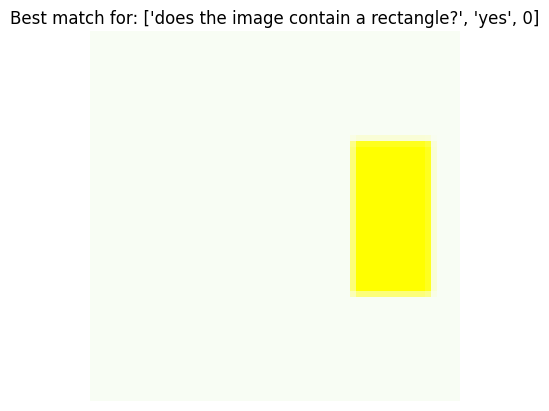

In [31]:
similarities = []

for emb in image_embeddings:
  print(emb.shape, text_embedding.shape)
  sim = np.dot(text_embedding, emb.T)
  similarities.append(sim.item())

best_idx = np.argmax(similarities)

plt.imshow(images[best_idx])
plt.axis('off')
plt.title(f"Best match for: {query}")
plt.show()


In [32]:
print(f"Total image embeddings: {len(image_embeddings)}")
print(f"Text embedding shape: {text_embedding.shape}")

for emb in image_embeddings:
    print(emb.shape)

Total image embeddings: 10
Text embedding shape: (1, 512)
(1, 512)
(1, 512)
(1, 512)
(1, 512)
(1, 512)
(1, 512)
(1, 512)
(1, 512)
(1, 512)
(1, 512)


### **BLIP MODEL**